# EDA of Airbnb's in New York City

## Purpose
Airbnb is an online platform that helps people either find or supply lodging for guests traveling or looking to getaway. They've loudly disrupted the hotel indsutry, and if you haven't heard of them by now, I hope this notebook gives you an idea of what they provide. 

Additonally, I'd like to use this notebook to analyze the Airbnb offerings in the Manhattan burough of New York City. From this analysis we can get a clear picture of what it's like to either be a host or guest looking for lodging in Manhattan.

This notebook will contian routine exploratory data analysis as well as data science tools such as Principle Component Analysis and Regression to help predict prices, location, proximity to Times Square, and much more!

Thank you for taking the time to read through my project!

## Predictions
I think from this dataset and my small qualitative knowledge of New York, we will see high prices in Midtown Manhattan and by such tourist attractions like Central Park and Times Square. 

I'm also predicting a relationship between the variable Reviews per Month and Price, where the Price of the lodging will decrease as the amount of reviews rises.

## Data
I sourced this data from Kaggle [at the following link](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). This data was scraped from Airbnb as part of an open source project *Inside Airbnb*, and I owe them the credit for making this analysis possible. It contains nearly 49 thousand Airbnb listings in NYC from 2019, along with their reported metrics.

## Notebook Setup
I'm using the following code to import the necessary packages for dataframe/mathematical/visualization tools. I will add specific packages as I need them, such as regression or formatting tools.

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Part 1: Unpacking our data!
This portion will be for understanding the data we're working with for this project. This will be the standard ETL part of our process to get us ready for analysis and modeling!

### Data Wrangling
Since there can be a lot of variance between boroughs, I want to keep this dataset to Manhattan listings only. The following processes will load and transform our data so that it's of quality and fits our desires.

In [3]:
nyc_bnb = pd.read_csv('AB_NYC_2019.csv')
nyc_dim = nyc_bnb.shape
print(f'Our dataset contains {nyc_dim[0]} rows of data, with {nyc_dim[1]} numerical and categorical columns that help tell the story of our data.')
nyc_bnb.head(5)

Our dataset contains 48895 rows of data, with 16 numerical and categorical columns that help tell the story of our data.


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### Making Sense of New York City
New York City is broken up into 5 "boroughs" or as this dataset calls them "neighborhood_group" and they're pretty distinctive. For this reason, I want to lower the possible variance in housing size, pricing, and location, so I'll be restricitng the dataset to Manhattan listings only. 

In [4]:
boroughs = nyc_bnb['neighbourhood_group'].value_counts().to_frame()
boroughs['Percent in NYC'] = [np.round(boroughs['neighbourhood_group'][hood]/sum(boroughs['neighbourhood_group'])*100, 4) for hood in boroughs.index]
boroughs.rename(columns = {'neighbourhood_group':'Borough'})

,Borough,Percent in NYC
Manhattan,21661,44.3011
Brooklyn,20104,41.1167
Queens,5666,11.5881
Bronx,1091,2.2313
Staten Island,373,0.7629


We can now see that Manhattan makes up 44.3% of our data, with Brooklyn trailing at 41.17% and the other Boroughs (Queens, Bronx, and Staten Island) trailing far behind. We will now split the data into Manhattan and non-Manhattan subsets for easier Manhattan analysis.

In [5]:
manhattan_bnb = nyc_bnb[nyc_bnb['neighbourhood_group'] == 'Manhattan']
non_manhattan_bnb = nyc_bnb[nyc_bnb['neighbourhood_group'] != 'Manhattan']
man_dim = manhattan_bnb.shape
perc_change = np.round(((nyc_dim[0] - man_dim[0]) / man_dim[0]) * 100, 2)
print(f'Our Manhattan dataset contains {man_dim[0]} rows of data, with the same {man_dim[1]} numerical and categorical columns that help tell the story of our data. This is a {perc_change}% reduction ({(nyc_dim[0] - man_dim[0])} less values) in our entries, but still a feasible amount to paint conclusions from.')
display(manhattan_bnb.head(5))

Our Manhattan dataset contains 21661 rows of data, with the same 16 numerical and categorical columns that help tell the story of our data. This is a 125.73% reduction (27234 less values) in our entries, but still a feasible amount to paint conclusions from.


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220


### Comparing the Manhattan listings against the non-Manhattan listings
Now that I've split the data, let's compare some dashboard statistics on select numerical columns. We see that average price in Manhattan for a night's stay is \\$196.88 while in non-Manhattan areas it's \\$117.60, which is a 40.27% drop in pricing. Now, we should understand that most tourism attractions and business are done in Manhattan, greatly increasing the demand for lodging there.

We can confirm this theory with the bar plot, which shows that Manhattan has higher prices for every room type.

In [6]:
num_cols = ['price', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
display(manhattan_bnb[num_cols].describe().style.set_caption("Manhattan Listings"))
display(non_manhattan_bnb[num_cols].describe().style.set_caption("Non-Manhattan Listings"))

,price,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,21661,21661,16632,21661,21661
mean,196.876,20.9856,1.27213,12.7913,111.979
std,291.383,42.5723,1.62825,48.2348,132.678
min,0,0,0.01,1,0
25%,95,1,0.17,1,0
50%,150,4,0.61,1,36
75%,220,19,1.89,2,230
max,10000,607,58.5,327,365


,price,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,27234,27234,22211,27234,27234
mean,117.601,25.095,1.44892,2.65227,113.419
std,182.303,45.9829,1.71462,7.3174,130.776
min,0,0,0.01,1,0
25%,58,1,0.21,1,0
50%,85,6,0.81,1,52
75%,139,27,2.17,2,223.75
max,10000,629,20.94,232,365


### Data Cleaning
Now that we've separated our data, we should further clean it up. This means getting rid of "useless" columns, finding any null values, or getting rid of potential outliers (if someone lists their apartment for \\$0 or \\$1 million). So, first thing I'll do is see how many null or empty values exist in our data, since this data is scraped straight from Airbnb in a consistent manner, there *shouldn't* be many errors.

In [7]:
manhattan_bnb.isnull().sum()

id                                   0
name                                 9
host_id                              0
host_name                            9
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       5029
reviews_per_month                 5029
calculated_host_listings_count       0
availability_365                     0
dtype: int64

As I guessed, the data is pretty clean, aside from the 9 values with no names for the host, these may suggest some error on Airbnb or the host's behalf, but they all have host ID numbers still, so I'll keep them. The other notable nulls were the 5,029 missing review values, but these are likely due to no reviews being left (which is common) or the property not being rented out yet, so they're staying in the data set. Here's a look at those null host name entries (note that they still have ID numbers):

In [8]:
manhattan_bnb[pd.isnull(manhattan_bnb[['host_name']]).any(axis=1)]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
5745,4183989,SPRING in the City!! Zen-Style Tranquil Bedroom,919218,NaN,Manhattan,Harlem,40.80606,-73.95061,Private room,86,3,34,2019-05-23,1.00,1,359
9817,7556587,Sunny Room in Harlem,39608626,NaN,Manhattan,Harlem,40.82929,-73.94182,Private room,28,1,1,2015-08-01,0.02,1,0
15174,12113879,"Sunny, Large West Village 1 BR Near Everything",5300585,NaN,Manhattan,Chelsea,40.73949,-73.99801,Entire home/apt,220,4,81,2019-07-02,2.11,1,217
27777,21787094,Spacious and Bright Midtown East Apartment,415290,NaN,Manhattan,Upper East Side,40.76436,-73.96836,Entire home/apt,325,1,0,NaN,NaN,1,0
27962,21867710,Amazing room in the centre on Manhatten! Welcome!,159156636,NaN,Manhattan,Hell's Kitchen,40.75668,-73.99097,Private room,120,1,89,2019-01-01,5.16,3,0
28042,21901156,Best Deal! Lovely place in Manhattan! Time Squ...,159156636,NaN,Manhattan,Hell's Kitchen,40.75656,-73.99063,Private room,120,1,109,2019-01-01,5.97,3,0
28274,21990808,***SLEEPING IN THE GOLDEN PLACE***,159156636,NaN,Manhattan,Hell's Kitchen,40.75835,-73.99065,Private room,120,1,88,2018-12-14,4.93,3,0
30570,23660605,Private Bedroom w/ Balcony view of Central Park,177146433,NaN,Manhattan,East Harlem,40.79766,-73.94824,Private room,139,1,6,2018-08-12,0.46,1,0
32193,25180572,Beautiful Cozy Studio Apt. UWS,119609345,NaN,Manhattan,Upper West Side,40.77701,-73.97667,Entire home/apt,180,4,0,NaN,NaN,1,0


# Part 2: Exploratory Data Analysis
In this portion I will try and make sense of the data with various visualizations and statistical processes.

### Examining Relationships
It's fair to think that room types will have an effect on pricing or that location may effect pricing, and we can test it all! The following plots will examine various relationships that may help guide our prediciton testing. I used the following plot to confirm that Manhattan prices would be higher for every room on average than every other borough.

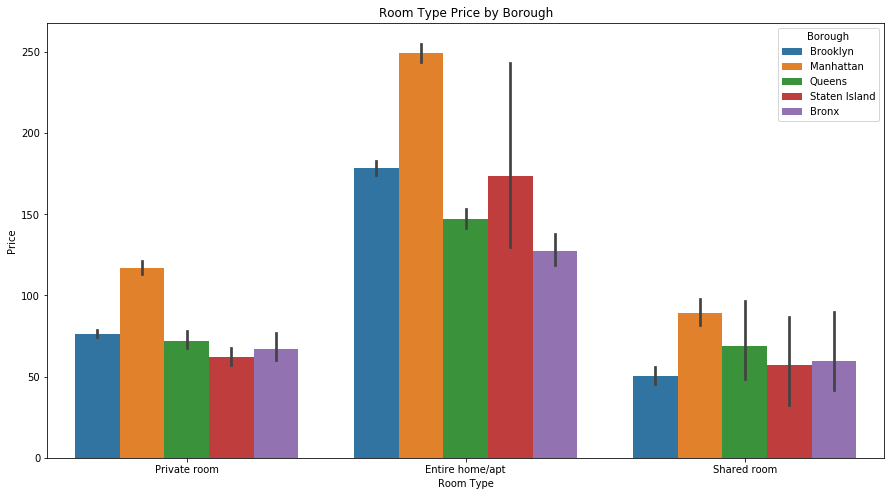

In [9]:
plt.figure(figsize=(15,8))
#sns.set(style = 'whitegrid')
display(sns.barplot(x = 'room_type', y = 'price', hue = 'neighbourhood_group', data = nyc_bnb))
plt.title('Room Type Price by Borough')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.legend(title = 'Borough');

### Making Sense of Manhattan
Manhattan is a large and vast borough of New York City containing many attractions, so I'm going to use various plots to help us understand how price may fluctuate around Manhattan. Sticking by my prediction, I think we will see higher prices surrounding Central Park and Times Square.

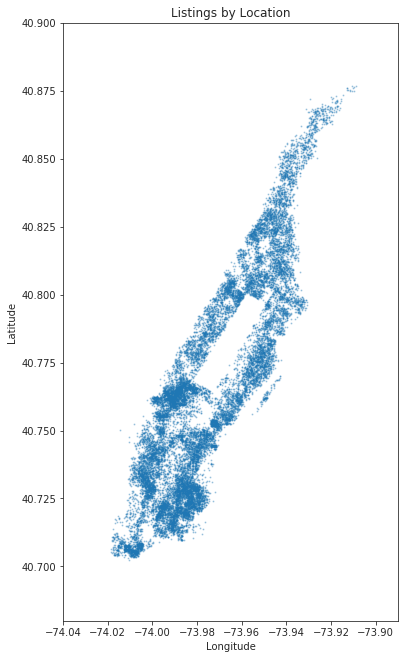

In [10]:
def listing_scatter(df):
    plt.scatter(df['longitude'], df['latitude'], s = 1, alpha = 0.3)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Listings by Location')
    
sns.set_style("ticks")
plt.figure(figsize = (6, 11))
plt.ylim([40.68, 40.9])
plt.xlim([-74.04, -73.89])
listing_scatter(manhattan_bnb)

We see a lot of grouping in the SoHo (South of Houston St.), Financial District, Lower East Side and Midtown area as we predicted. Now we can try and see how these areas are related to price. To answer such questions like "Which part of Manhattan will have the cheapest single rooms or entire houses or apartments?" First, lets see how Manhattan is divided up, and then we can see where the most expensive listings are.

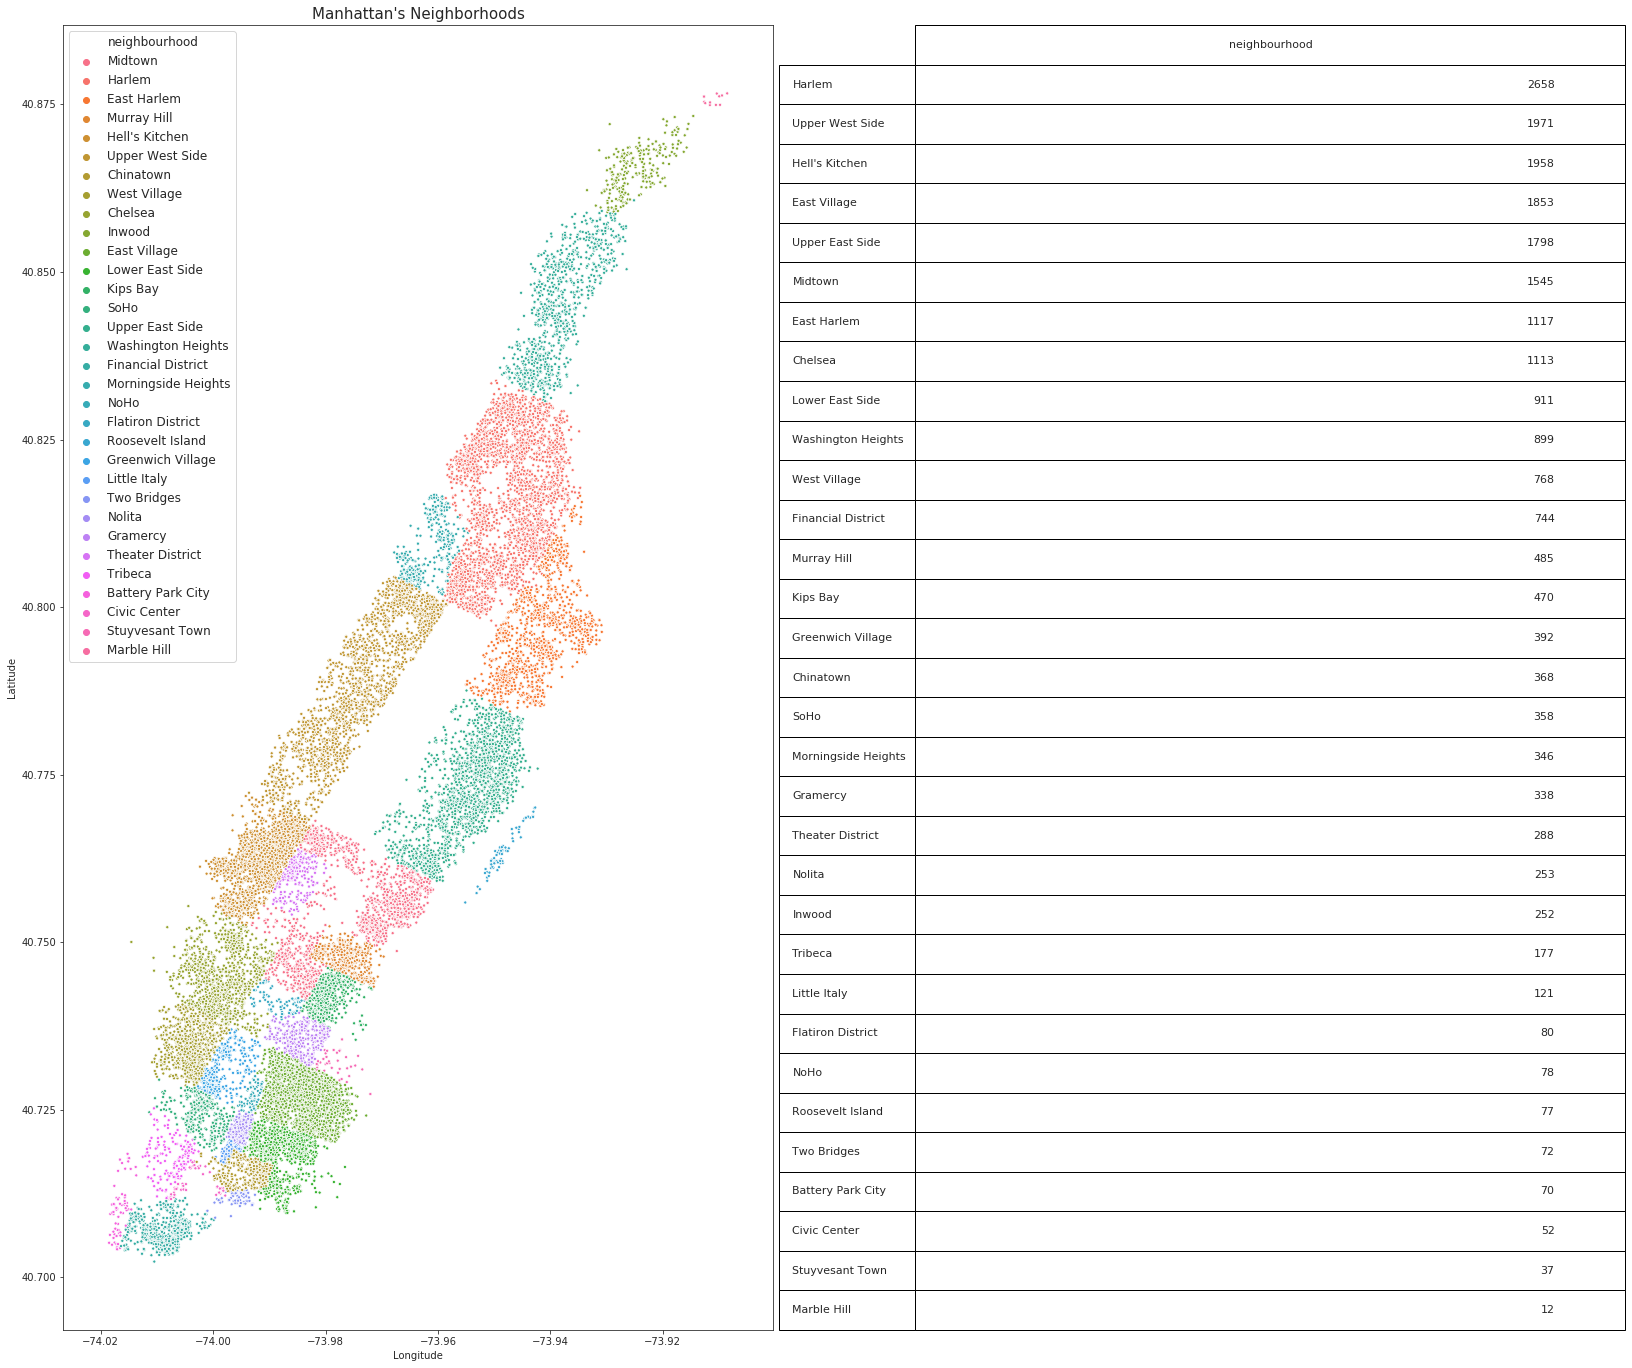

In [79]:
neighbor = manhattan_bnb['neighbourhood'].value_counts().to_frame()

fig = plt.figure(figsize = (28, 24))
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.scatterplot(x = 'longitude', y = 'latitude', hue = 'neighbourhood', s = 10, data = manhattan_bnb)
#ax1.ylim([40.68, 40.9])
#ax1.xlim([-74.04, -73.89])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Manhattan\'s Neighborhoods', fontsize = 15)
plt.legend(fontsize = 12)
ax2 = fig.add_subplot(1,2,2)
font_size=11
bbox=[0, 0, 1, 1]
ax2.axis('off')
hood_table = ax2.table(cellText = neighbor.values, rowLabels = neighbor.index, bbox = bbox, colLabels=neighbor.columns)
hood_table.auto_set_font_size(False)
hood_table.set_fontsize(font_size);

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


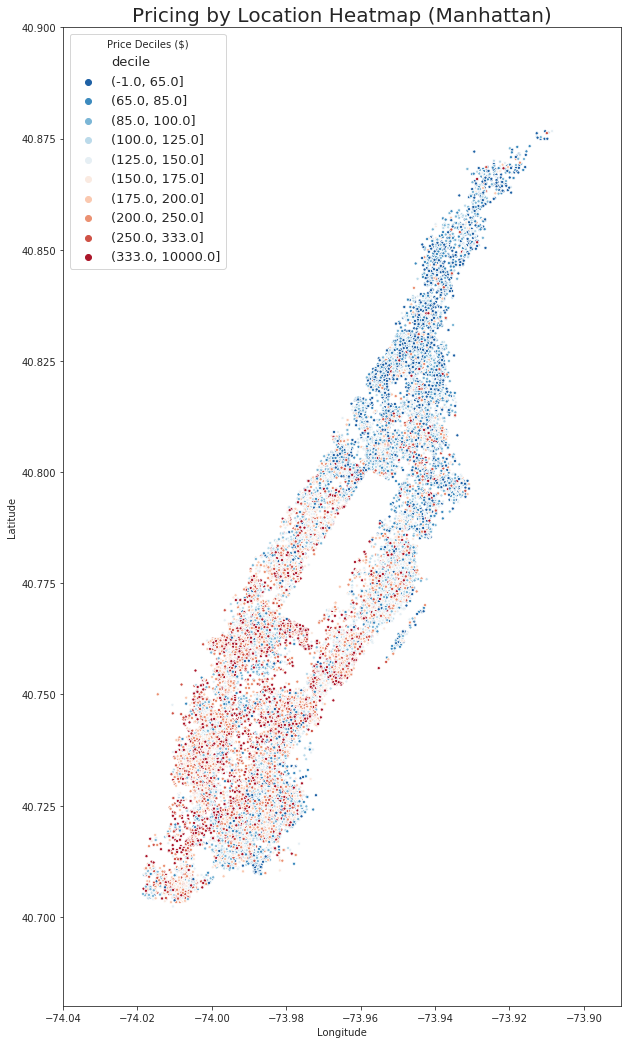

In [11]:
manhattan_bnb['decile'] = pd.qcut(manhattan_bnb['price'], q = 10, precision = 0)
plt.figure(figsize = (10, 18))
plt.ylim([40.68, 40.9])
plt.xlim([-74.04, -73.89])
cmap = sns.color_palette("RdBu_r", 10)
sns.scatterplot(x = 'longitude', y = 'latitude', hue = 'decile', s = 10, palette = cmap, data = manhattan_bnb)
plt.title('Pricing by Location Heatmap (Manhattan)', fontsize = 20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title = 'Price Deciles ($)', fontsize = 13);

We can clearly see a relationship between price and location from this plot. As pricing is much higher (top decile in some cases) in the Times Square and SoHo areas. But, the most listings are in the Harlem area, just north of Central Park. I'd like to personally acknowledge that this graph isn't the greatest, as it may be a victim of over-plotting, and certain points may get buried, but I believe it paints an accurate picture that we can further test in the predictions side of this analysis.

We can further examine these relationships with a correlation matrix, to find some interesting results. We, see that price is negatively correlated with latitude (and longitude), which indicates that the more expensive properties are on the lower west side, and our 'Pricing by Location Heatmap' confirms this.

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,1.000000,0.610679,-0.035037,-0.045945,0.046707,-0.003934,-0.315322,0.310275,0.193811,0.130760
host_id,0.610679,1.000000,-0.020104,-0.041009,0.050014,-0.008308,-0.153359,0.311510,0.219072,0.211937
latitude,-0.035037,-0.020104,1.000000,0.856838,-0.146242,-0.038349,0.037841,0.011076,-0.166801,-0.036154
longitude,-0.045945,-0.041009,0.856838,1.000000,-0.163758,-0.043712,0.046721,-0.000419,-0.182278,-0.048286
price,0.046707,0.050014,-0.146242,-0.163758,1.000000,0.028690,-0.060914,-0.011276,0.045157,0.118033
minimum_nights,-0.003934,-0.008308,-0.038349,-0.043712,0.028690,1.000000,-0.087005,-0.123121,0.137263,0.202386
number_of_reviews,-0.315322,-0.153359,0.037841,0.046721,-0.060914,-0.087005,1.000000,0.517994,-0.099349,0.120990
reviews_per_month,0.310275,0.311510,0.011076,-0.000419,-0.011276,-0.123121,0.517994,1.000000,-0.001518,0.158542
calculated_host_listings_count,0.193811,0.219072,-0.166801,-0.182278,0.045157,0.137263,-0.099349,-0.001518,1.000000,0.315751
availability_365,0.130760,0.211937,-0.036154,-0.048286,0.118033,0.202386,0.120990,0.158542,0.315751,1.000000


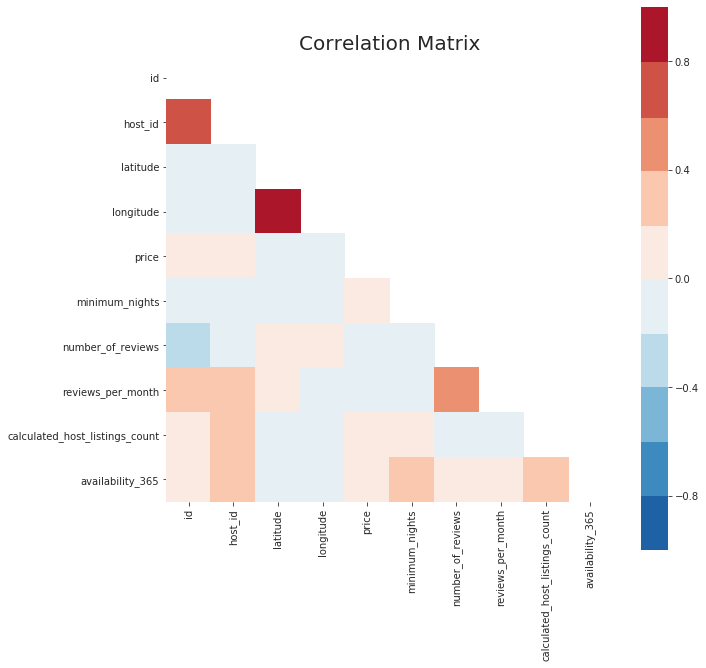

In [12]:
r = manhattan_bnb.corr()
upperTri = np.triu(np.ones_like(r, dtype=np.bool))
plt.figure(figsize = (10,10))
sns.heatmap(r, mask = upperTri, cmap = cmap, center = 0, vmin = -1, square = True)
plt.title('Correlation Matrix', fontsize = 20)
r

### This project is a work in progress and work shown is not final.
Thank you for reading! 

-Hayden